# HRRP-ATR-VAE

## import

In [1]:
import scipy.io as scio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

from utils.dataloader import *
from models.E2EVAE import E2EVAE

In [2]:
train_path = r'datasets\Train_hrrp.mat'
test_path = r'datasets\Test_hrrp.mat'
batch_size = 32
epochs = 30
epochs_log = epochs/5
learning_rate = 0.001

## load data

一定要幅度归一化！！！loss明显降低！！！

In [3]:
from torchvision.transforms import Compose
train_ds = hrrpDataset(train_path, train=True, transform=Compose([AmplitudeNormalize(), To4DTensor()]))
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=batch_size,shuffle=True)
for labels in train_dl:
    print('labels:',labels[1])
    break

labels: tensor([1, 2, 1, 1, 2, 1, 0, 0, 0, 0, 2, 0, 2, 0, 1, 1, 0, 0, 1, 0, 1, 2, 2, 0,
        1, 1, 1, 1, 2, 1, 0, 1])


## model

### VAE

In [ ]:
model = VanillaVAE(1,256)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for epoch in range(epochs):
    # --------------------- train ---------------------
    model.train()
    for x,y in train_dl:
        output = model(x)
        x1,_,mu,log_var = output
        loss = model.loss_function(*output,M_N=0.1)['loss']
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print("[{}/{}] loss: {}".format(epoch,epochs,loss.item()))

In [ ]:
x1 = model.generate(x)
                                                                                        
plt.figure(figsize=(8,4))
plt.tight_layout(pad=2)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(x[i].view(-1),label='raw')
    plt.plot(x1[i].view(-1).detach(),label='new')
    plt.legend()
    plt.title('{}'.format(y[i]))

### end-to-end VAE

In [6]:
model = E2EVAE(1,256)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for epoch in range(epochs):
    # --------------------- train ---------------------
    model.train()
    for x,y in train_dl:
        output = model(x)
        loss = model.loss_function(*output,labels=y,kld_weight=0.01,cls_weight=0.1,rec_weight=1)
        loss['loss'].backward()
        optimizer.step()
        optimizer.zero_grad()
    # print("[{}/{}] loss: {}".format(epoch,epochs,loss.item()))
    print("[{}/{}] loss: {:.4f}, rec: {:.4f}, kld: {:.4f}, cls: {:.4f}".format(
        epoch,epochs,
        loss['loss'].item(),
        loss['Reconstruction_Loss'].item(),
        loss['KLD'].item(),
        loss['Classify_Loss'].item()
    ))

[0/30] loss: 0.3632, rec: 0.0323, kld: -0.2278, cls: 0.1031
[1/30] loss: 0.2389, rec: 0.0167, kld: -0.1162, cls: 0.1060
[2/30] loss: 0.1614, rec: 0.0103, kld: -0.0438, cls: 0.1073
[3/30] loss: 0.1628, rec: 0.0139, kld: -0.0327, cls: 0.1162
[4/30] loss: 0.1369, rec: 0.0114, kld: -0.0174, cls: 0.1081
[5/30] loss: 0.1459, rec: 0.0194, kld: -0.0149, cls: 0.1115
[6/30] loss: 0.1528, rec: 0.0152, kld: -0.0209, cls: 0.1167
[7/30] loss: 0.1350, rec: 0.0139, kld: -0.0099, cls: 0.1111
[8/30] loss: 0.1363, rec: 0.0144, kld: -0.0102, cls: 0.1116
[9/30] loss: 0.1342, rec: 0.0135, kld: -0.0080, cls: 0.1128
[10/30] loss: 0.1283, rec: 0.0158, kld: -0.0078, cls: 0.1046
[11/30] loss: 0.1304, rec: 0.0160, kld: -0.0082, cls: 0.1063
[12/30] loss: 0.1306, rec: 0.0096, kld: -0.0070, cls: 0.1140
[13/30] loss: 0.1281, rec: 0.0176, kld: -0.0060, cls: 0.1045
[14/30] loss: 0.1216, rec: 0.0097, kld: -0.0087, cls: 0.1032
[15/30] loss: 0.1206, rec: 0.0092, kld: -0.0063, cls: 0.1051
[16/30] loss: 0.1244, rec: 0.0072,

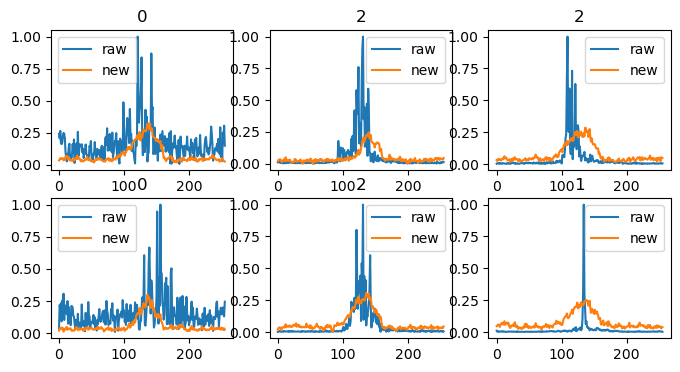

In [7]:
x1 = model.generate(x)
                                                                                        
plt.figure(figsize=(8,4))
plt.tight_layout(pad=2)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(x[i].view(-1),label='raw')
    plt.plot(x1[i].view(-1).detach(),label='new')
    plt.legend()
    plt.title('{}'.format(y[i]))